# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

In [1]:
# To help you get started...
from IPython.display import display
from os.path import join, isfile
from os import listdir

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
import re
import numpy as np
%matplotlib inline 

import sys
!{sys.executable} -m pip install hdbscan
import hdbscan


I stored all the data in a folder called exampleco_data. This first cell loads machine_0's data to check and see the data

The second cell iterates through all files that fit the 'machine_XX.csv' file name format and joins them all together

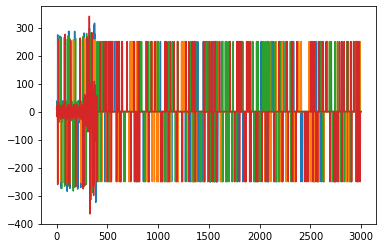

In [2]:
#Folderpath to exampleco's data
path = '../exampleco_data' 

#Test for data
df_machine_0 = pd.read_csv(join(path, 'machine_0.csv'),index_col=0)

plt.plot(range(len(df_machine_0)), df_machine_0)
plt.show()

In [3]:
df_machine_data = pd.DataFrame()

files = [f for f in listdir(path) if isfile(join(path, f))]

#Iterate through files and join data
for file in files:
    if re.match(r'machine_[0-9]+.csv', file):
        df_ind_machine_data = pd.read_csv(join(path, file),index_col=0)
        df_ind_machine_data['source'] = file
        df_machine_data = df_machine_data.append(df_ind_machine_data)
        print(file + ' added to dataframe')

df_ind_machine_data = pd.read_csv(join(path, file),index_col=0)
orig_columns = df_ind_machine_data.columns.tolist()
        

machine_0.csv added to dataframe
machine_1.csv added to dataframe
machine_10.csv added to dataframe
machine_11.csv added to dataframe
machine_12.csv added to dataframe
machine_13.csv added to dataframe
machine_14.csv added to dataframe
machine_15.csv added to dataframe
machine_16.csv added to dataframe
machine_17.csv added to dataframe
machine_18.csv added to dataframe
machine_19.csv added to dataframe
machine_2.csv added to dataframe
machine_3.csv added to dataframe
machine_4.csv added to dataframe
machine_5.csv added to dataframe
machine_6.csv added to dataframe
machine_7.csv added to dataframe
machine_8.csv added to dataframe
machine_9.csv added to dataframe


First I want to normalize the 4 datasets with 0 mean (no bias) and a standard deviation of 1 so that we dont run into numerical issues later on and/or so that the different variables are of the same magnitude. I also want to save these means and standard deviations in case we need to re-normalize individual machines.

In [4]:
def normalize(df_col):
    return ((df_col - df_col.mean())/df_col.std(), df_col.mean(), df_col.std())

def normalize_dataset(df, cols):
    df_mean_std = pd.DataFrame(columns = ['mean', 'std'])
    for col in cols:
        (df[col + '_normalized'], mean, std) = normalize(df[col])
        df_mean_std.loc[col, 'mean'] = mean
        df_mean_std.loc[col, 'std'] = std
    return (df, df_mean_std)
    
normalized_columns = [col + '_normalized' for col in orig_columns]
(df_machine_data, df_col_stats) = normalize_dataset(df_machine_data, orig_columns)

I see that the distribution of the 4 variables show that they lie in pretty distinct and easily recognizable cluster. I suspect these are the points from the noise and/or communication errors. I also calculated (not captured in this notebook) that the occurence of noise seems to be independent amongst the 4 varaibles (i.e. if one sensor experiences noise/communication error, this does NOT affect the likelihood that the others will experience noise). 

All 3 of the variables seem to experience noise 4 sigma away from the majority of their signals. I decided to filter out any data points 3 that are 3 standard deviations/sigmas away from the mean. I replaced them with linearly interpolated points instead.

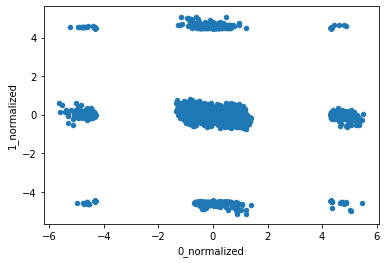

In [5]:
axes = df_machine_data.plot.scatter('0_normalized', '1_normalized')

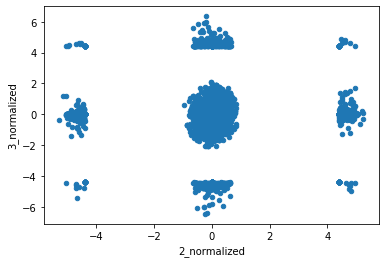

In [6]:
axes = df_machine_data.plot.scatter('2_normalized', '3_normalized')

In [7]:
#Interpolate values outside of these number of sigmas
SIGMA_THRESHOLD = 3

def clean_data_col(df_col):
    df_cleaned_col = df_col.apply(lambda x: x if abs(x)<SIGMA_THRESHOLD else np.nan)
    df_cleaned_col.interpolate(axis='index', inplace = True)
    return df_cleaned_col

def clean_dataset(df, cols):
    for col in cols:
        df[col + '_cleaned'] = clean_data_col(df[col + '_normalized'])
    return df
    
cleaned_columns = [col + '_cleaned' for col in orig_columns]
df_machine_data = clean_dataset(df_machine_data, orig_columns)

Applying this methodology to one turbine, I see 3 distinct areas: normal sinusoids presumably for normal operation, an eratic exponentially growing sinuoid for faulty operation and a series of near-zero values likely for failed operations

In [8]:
df_machine_2 = df_machine_data.loc[df_machine_data['source'] == 'machine_2.csv',:]

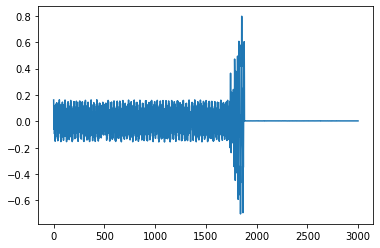

In [9]:
plt.plot(range(len(df_machine_2['1_cleaned'])), df_machine_2['1_cleaned'])
plt.show()

Zooming into normal operation, I apply a Fast Fourier Transform to see it in frequency domain

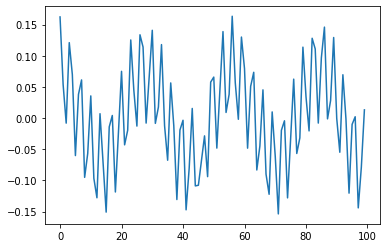

In [10]:
start = 0
end = 100

plt.plot(range(start, end), df_machine_2['1_cleaned'][start:end])
plt.show()

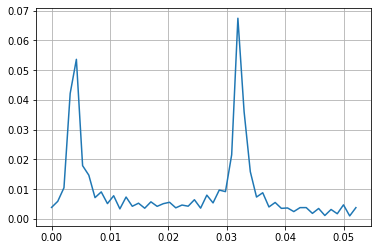

In [11]:
T = 9.6 #s
N = end-start

#Visualize frequency domain: X axis is Hz, Y axis is amplitude
yf = fft(df_machine_2['1_cleaned'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

Taking a look at the suspected faulty period and its associated frequency domain graph

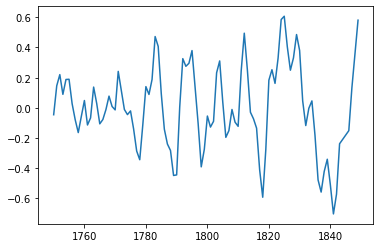

In [12]:
start = 1750
end = 1850

plt.plot(range(start, end), df_machine_2['1_cleaned'][start:end])
plt.show()

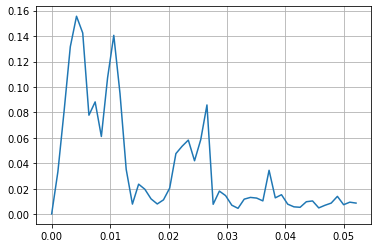

In [13]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_cleaned'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

I see a lot of noise in the frequency domain so I will smooth the waveform by taking a moving average of the previous X elements (X being 5 for now). Unfortunately will shift the phase of the signal which could affect results. I could take the moving average centered on the point in question, but I would be unable to do this if I were to deploy this in a live setting (because you do not have data points in the future)

In [14]:
MOVING_AVERAGE = 5

def smooth_data_col(df_col):
    df_smoothed_col = df_col.rolling(MOVING_AVERAGE, win_type = 'triang').mean()
    return df_smoothed_col

def smooth_dataset(df, cols):
    for col in cols:
        df[col + '_smoothed'] = smooth_data_col(df[col + '_cleaned'])
    return df
    
smoothed_columns = [col + '_smoothed' for col in orig_columns]
df_machine_data = smooth_dataset(df_machine_data, orig_columns)

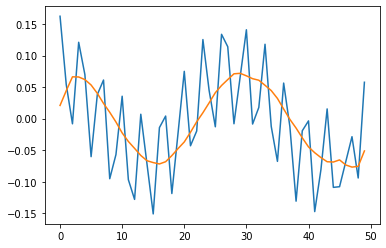

In [15]:
df_machine_2 = df_machine_data.loc[df_machine_data['source'] == 'machine_2.csv',:]
start = 0
end = 50

plt.plot(range(start, end), df_machine_2[['1_cleaned','1_smoothed']][start:end])
plt.show()

I see the smoothed waveform gives me a much more distinct peak in our frequency domain

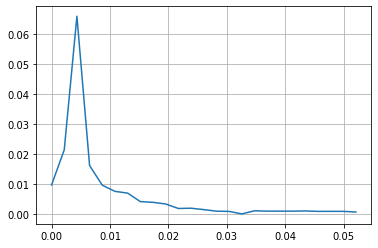

In [16]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_smoothed'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

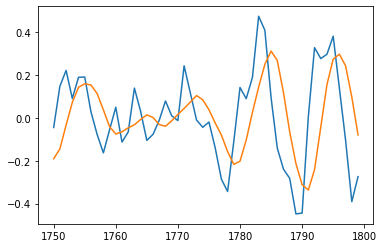

In [17]:
df_machine_2 = df_machine_data.loc[df_machine_data['source'] == 'machine_2.csv',:]
start = 1750
end = 1800

plt.plot(range(start, end), df_machine_2[['1_cleaned','1_smoothed']][start:end])
plt.show()

The suspected faulty period has a higher peak at a higher frequency

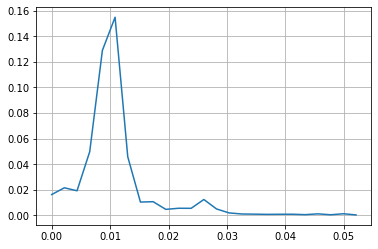

In [18]:
T = 9.6 #s
N = end-start

yf = fft(df_machine_2['1_smoothed'][start:end].tolist())
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

This graph seems like a good way to differentiate between the different modes. Over a moving window of X points (FFT_HORIZON), I apply a fast fourier transform. To summarize all the information captured in the frequency domain into two numbers we calculate the Total Harmonic Distortion (THD) of that window and the amplitude of the most significant harmonic (vmax). I apply this calculation to each of the machines' signals. I also added a small bias in the denominator in order to have a low THD in cases where there is small amplitudes across various harmonics which should technically result in high THD, but is not of interest to us (e.g. there is some signal noise on a dead machine).

Warning: This cell below takes a couple minutes to run.

In [19]:
FFT_HORIZON = 30
DENOM_BIAS = 0.002

def calculate_THD(yf):
    v_max = max(yf)
    v_non_fund = yf.copy()
    v_non_fund.remove(v_max)
    num = np.linalg.norm(v_non_fund)
    denom = v_max
    return num/(denom+DENOM_BIAS)

def rolling_fft_to_thd(df):
    lst = df.tolist()
    yf = fft(lst)
    yf = 2.0/FFT_HORIZON * np.abs(yf[0:FFT_HORIZON//2])
    return calculate_THD(np.abs(yf[0:FFT_HORIZON//2]).tolist())

def fft_v_max(df):
    lst = df.tolist()
    yf = fft(lst)
    yf = 2.0/FFT_HORIZON * np.abs(yf[0:FFT_HORIZON//2])
    v_max = max(yf)
    return v_max

def distortion_col(df_col):
    df_distort_col = df_col.rolling(FFT_HORIZON).apply(rolling_fft_to_thd)
    df_distort_col.fillna(method = 'backfill', inplace = True)
    return df_distort_col

def vmax_col(df_col):
    df_vmax_col = df_col.rolling(FFT_HORIZON).apply(fft_v_max)
    df_vmax_col.fillna(method = 'backfill', inplace = True)
    return df_vmax_col

machine_list = df_machine_data['source'].unique().tolist()

for machine in machine_list:
    for col in orig_columns:
        machine_cols = df_machine_data['source'] == machine
        df_machine_data.loc[machine_cols, col + '_THD'] = distortion_col(df_machine_data.loc[machine_cols, col + '_smoothed'])
        df_machine_data.loc[machine_cols, col + '_FFT_vmax'] = vmax_col(df_machine_data.loc[machine_cols, col + '_smoothed'])

I normalize the THD and Vmax features before doing any training

In [20]:
THD_columns = [col + '_THD' for col in orig_columns]
FFT_vmax_columns = [col + '_FFT_vmax' for col in orig_columns]

df_machine_data, df_dummy = normalize_dataset(df_machine_data, THD_columns)
df_machine_data, df_dummy = normalize_dataset(df_machine_data, FFT_vmax_columns)

THD_normalized_columns = [col + '_THD_normalized' for col in orig_columns]
FFT_vmax_normalized_columns = [col + '_FFT_vmax_normalized' for col in orig_columns]

Taking a look at one machine and the engineered features vs the cleaned signal, we see that there is a distinct change in the THDs and Vmaxs during failures, which will hopefully result in a classifier that can discriminate between these operating modes

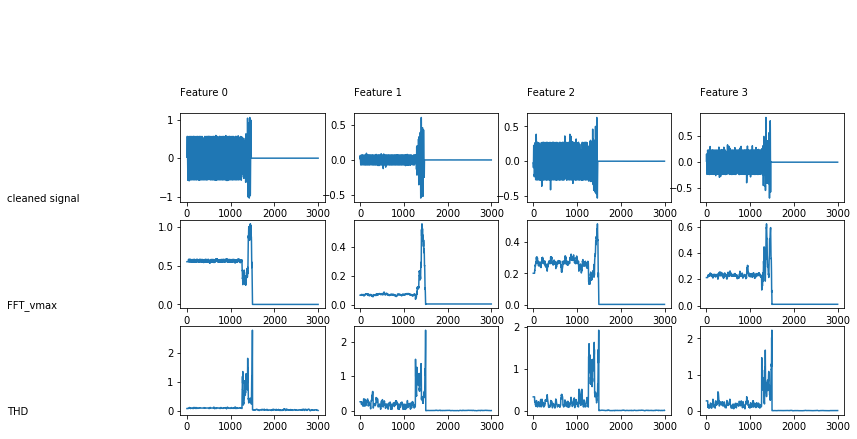

In [21]:
machine = 'machine_7.csv'
machine_cols = df_machine_data['source'] == machine
df_machine = df_machine_data.loc[machine_cols, :]

start = 0
end = 3000

plt.figure(figsize = (15,7.5))

for i in range (4):
    
    plt.subplot(4, 5, i + 7)
    name = str(i) + '_smoothed'
    plt.plot(range(start, end), df_machine[name][start:end])
    
    plt.subplot(4, 5, i + 12)
    name = str(i) + '_FFT_vmax'
    plt.plot(range(start, end), df_machine[name][start:end])
    
    plt.subplot(4, 5, i + 17)
    name = str(i) + '_THD'
    plt.plot(range(start, end), df_machine[name][start:end])
    plt.subplot(4, 5, i+2)
    plt.annotate('Feature ' + str(i), (0,0))
    plt.axis('off')

    
plt.subplot(4, 5, 6)
plt.annotate('cleaned signal', (0,0))
plt.axis('off')
    
plt.subplot(4, 5, 11)
plt.annotate('FFT_vmax', (0,0))
plt.axis('off')
    
plt.subplot(4, 5, 16)
plt.annotate('THD', (0,0))
plt.axis('off')

plt.show()

I decompose the engineered features into two components using primary component analysis to see if there are clear groupings. Primary component analysis allows us to distill the most information possible from a set of data. They are linear combinations of the input data and do not represent any real measurements.  In this case, no pattern immediately appear in 2 dimensions.

In [22]:
pca = PCA()
training_cols = FFT_vmax_normalized_columns+THD_normalized_columns
pca.fit(df_machine_data.loc[:,training_cols])
transformed_data = pca.transform(df_machine_data.loc[:,training_cols])
df_machine_data['pca_dim1'] = transformed_data[:,0]
df_machine_data['pca_dim2'] = transformed_data[:,1]

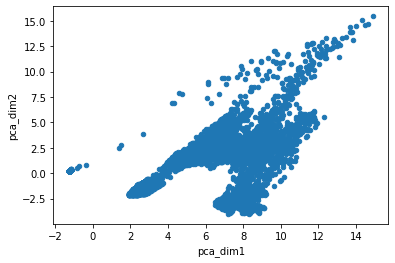

In [23]:
df_machine_data.plot.scatter('pca_dim1', 'pca_dim2')
plt.show()

At this point there are two options: I can hand label the data and apply supervised learnings techniques or I can apply unsupervised data as is. I opt to use KMeans, an unsupervised learning model, because a) I am not an expert on failures, b) hand labeling introduces my non-expert bias into the model and c) my time is expensive. Unsupervised learning's disadvantage is that there is no ground truth (no known label) so validation once again introduces human bias (e.g. a human selecting an unsupervised model does so based on its subjective judgement).

Normally, I would need to guess the number of clusters, but since I know there are only 3 modes, I use 3 clusters initially.

In [24]:
all_sources = df_machine_data['source'].unique().tolist()

training_sources = ['machine_0.csv',
                   'machine_1.csv',
                   'machine_2.csv',
                   'machine_3.csv',
                   'machine_4.csv',
                   'machine_5.csv',
                   'machine_6.csv',
                   'machine_7.csv',
                   'machine_8.csv',
                   'machine_9.csv',
                   'machine_10.csv',
                   'machine_11.csv',
                   'machine_12.csv',
                   'machine_13.csv',
                   'machine_14.csv',
                   'machine_15.csv']

validation_sources = [source for source in all_sources if source not in training_sources]

training_rows = df_machine_data['source'].isin(training_sources)
validation_rows = df_machine_data['source'].isin(validation_sources)

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_machine_data.loc[training_rows,training_cols].to_numpy())

Seeing the points clustered on the 2 primary components, I do see some unintuitive groupings appear

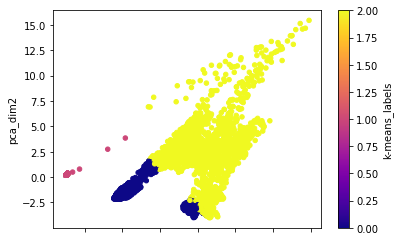

In [25]:
df_machine_data.loc[training_rows, 'k-means_labels'] = kmeans.labels_
df_machine_data.loc[training_rows,:].plot.scatter('pca_dim1', 'pca_dim2', c = 'k-means_labels', colormap='plasma')
plt.show()

When colouring the points on the time series, I see that this model generally categorizes the points in a manner that we would expect; there is normal operation followed by a period of faulty operation, followed by a final failed state. However, there is some model uncertainty in some areas where the model deems some 'normal' operation between period of intermittent 'faulty' operation. I could apply a label override (for example, once a certain number of consecutive points of 'faulty' label appear, relabel all consequent 'normal' labels as 'faulty'), but that would introduce the assumption that machines cannot recover from faulty states (they never do in these 20 machines, but I would require reassurances that it could never happen).

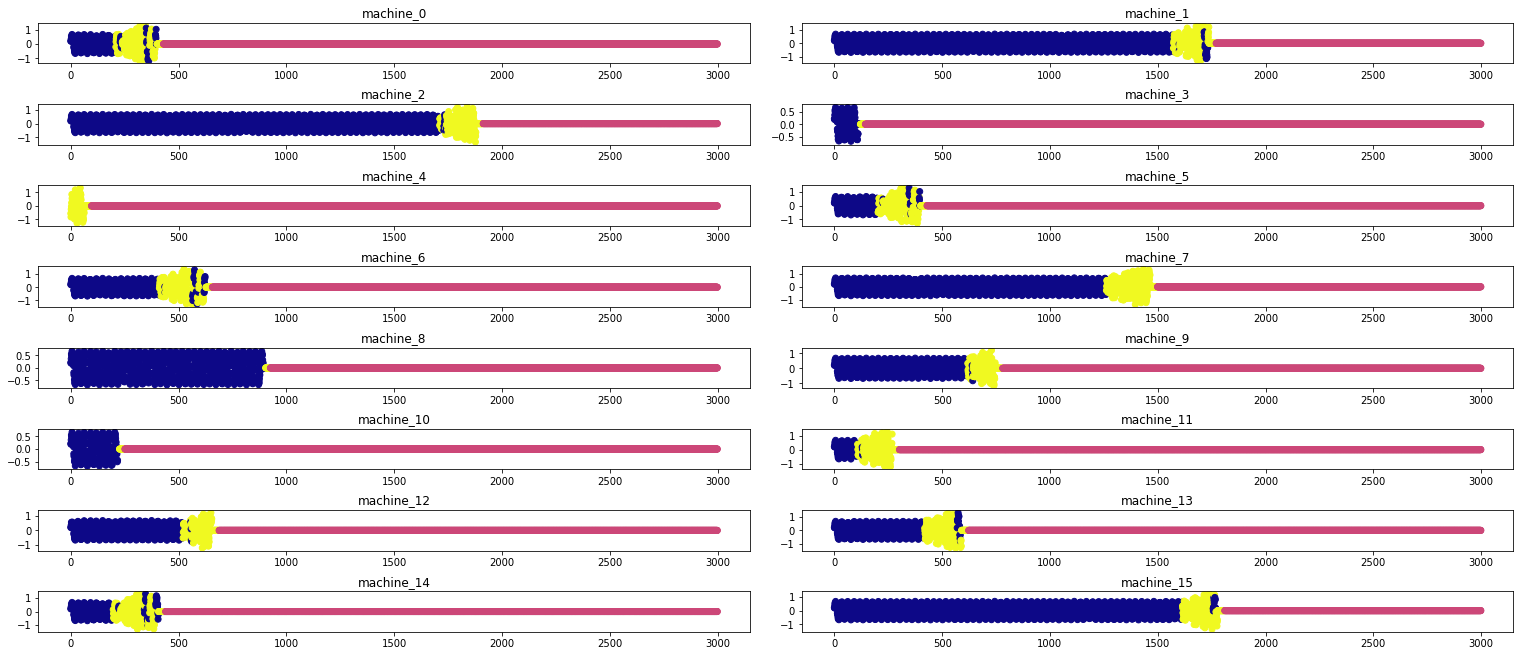

In [26]:
def plot_ts(df, sources, figheight = 21, figwidth = 9, labelname = 'k-means_labels', ts = '0_cleaned', min_val = 0, max_val = 2):
    start = 0
    end = 3000
    graphrows = int(np.ceil(len(sources)/2))
    train_fig, train_axes = plt.subplots(ncols=2, nrows=graphrows,figsize = (figheight,figwidth), constrained_layout=True)

    for i,machine in enumerate(sources):
        machine_cols = df['source'] == machine
        df_machine = df.loc[machine_cols, :]

        train_axes[i//2, i%2].scatter(range(len(df_machine)), df_machine[ts], c = df_machine[labelname], cmap='plasma', vmin=min_val, vmax = max_val)
        train_axes[i//2, i%2].set_title(machine.split('.')[0])
    plt.show()
    
plot_ts(df_machine_data, training_sources)

Applying this Kmeans clusters to withheld data (e.g. classifying data by looking for the closest cluster in the training data), we see that it does a decent job at classifying the states, albeit with some of the same problems as before

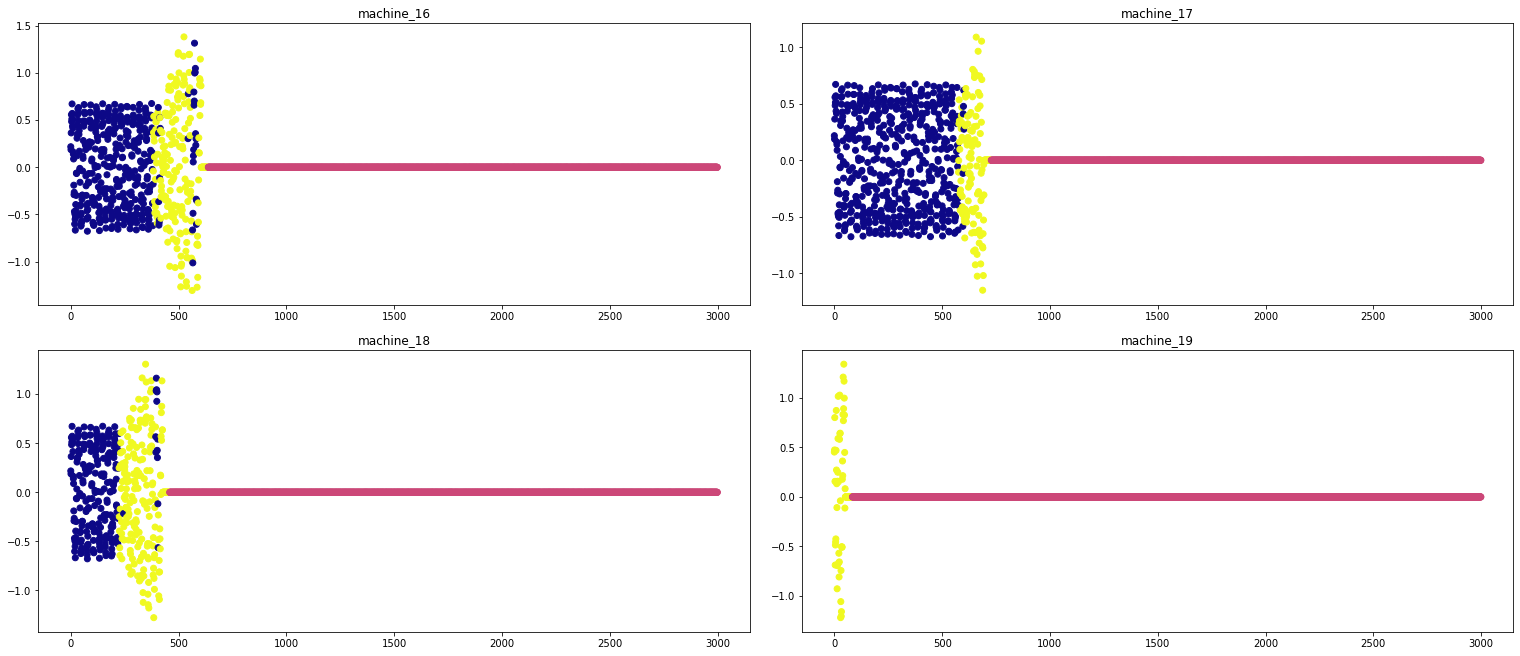

In [27]:
df_machine_data.loc[validation_rows, 'k-means_labels'] = kmeans.predict(df_machine_data.loc[validation_rows, training_cols].to_numpy())

plot_ts(df_machine_data, validation_sources)

Trying Kmeans with 4 clusters, we see that some of these problems disappear where some of the misclassified normal states are put into a second faulty state cluster. Looking at the primary components plot, we see that this makes some sense; in the previous 3-cluster kmeans version of this graph, the two 'legs' were in the normal cluster. Now, that right leg is a separate 'faulty cluster'. When looking at the time-series graphs that follow and matching the colors to the primary component graph, we see that the machine operates normally in the narrow blue region. It then destabilizes into the more spread out yellow region, as it nears failure it enters the orange region below. Failures are very narrowly clustered (and easily recognizable) near (0,0).

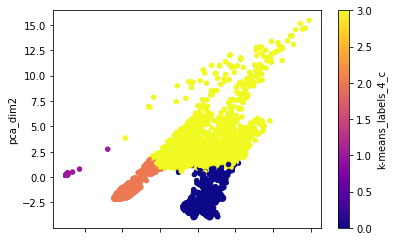

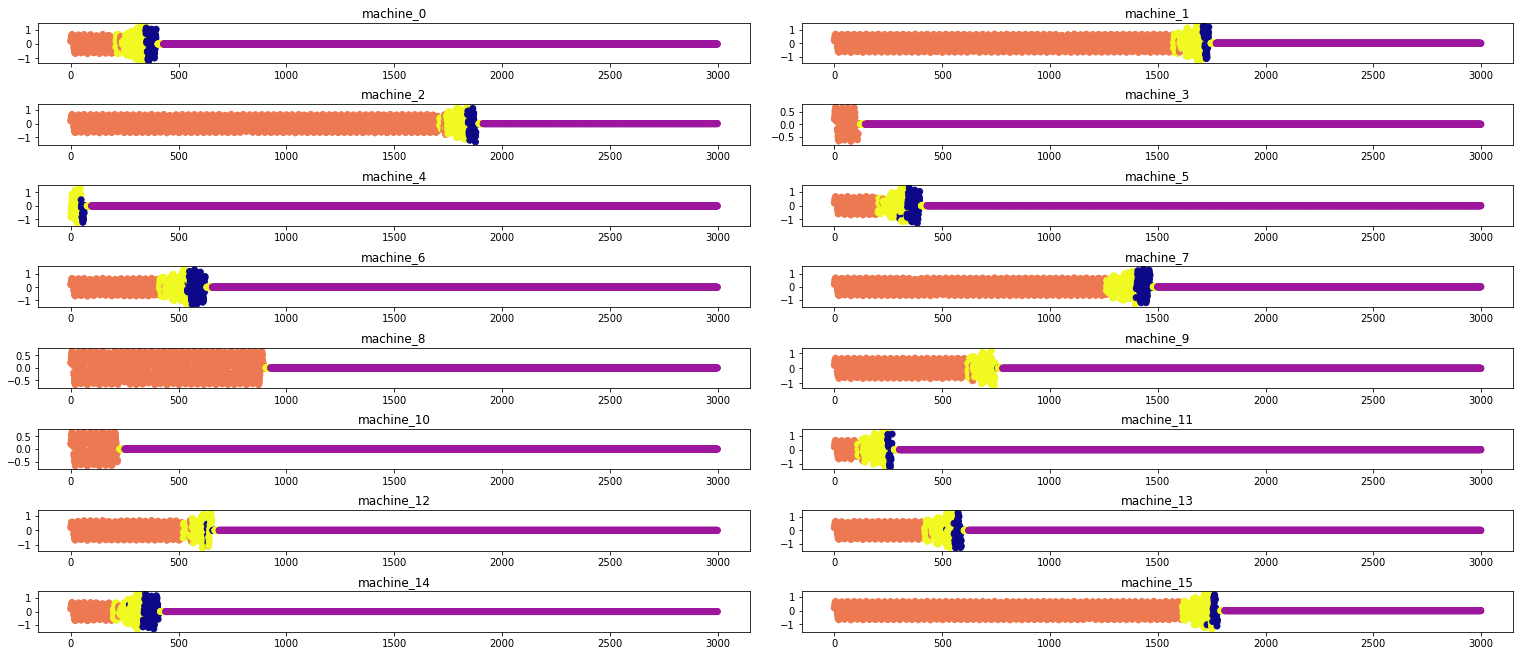

In [28]:
kmeans_4_c = KMeans(n_clusters=4, random_state=0).fit(df_machine_data.loc[training_rows,training_cols].to_numpy())
df_machine_data.loc[training_rows, 'k-means_labels_4_c'] = kmeans_4_c.labels_
df_machine_data.loc[training_rows,:].plot.scatter('pca_dim1', 'pca_dim2', c = 'k-means_labels_4_c', colormap='plasma')
plt.show()
    
plot_ts(df_machine_data, training_sources, labelname = 'k-means_labels_4_c', max_val = 3)

Validation appears to indicate that this is a a good classifier.

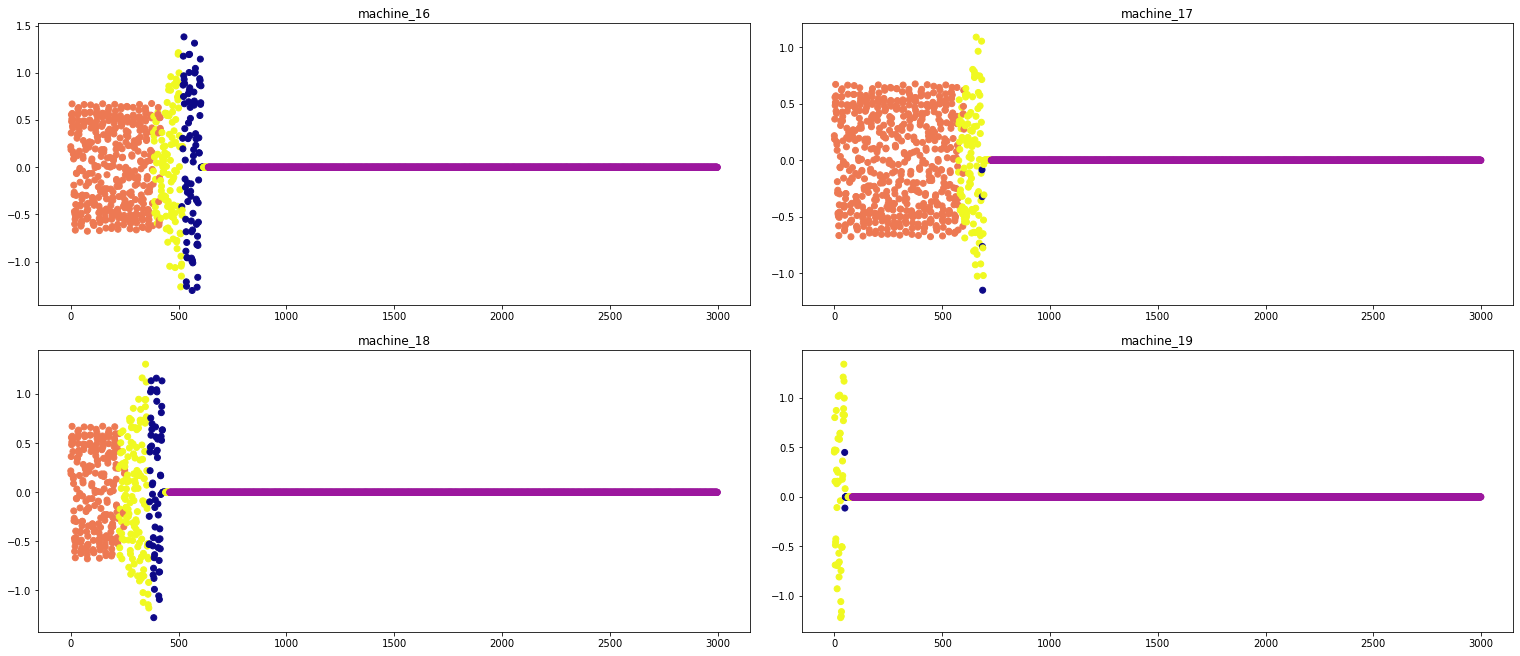

In [29]:
df_machine_data.loc[validation_rows, 'k-means_labels_4_c'] = kmeans_4_c.predict(df_machine_data.loc[validation_rows, training_cols].to_numpy())

plot_ts(df_machine_data, validation_sources, labelname = 'k-means_labels_4_c', max_val = 3)

I apply another unsupervised learning method, hierarchical density based spatial clustering of application with noise or HDBSCAN. This method immediately recognizes and classifies the three operating states, without need of the 4th state like KMeans. However, it should be noted that it did NOT cluster the faulty states as its own state, but considered all of them outliers. This means that HDBSCAN was only able to cluster the normal and failed operation states properly, but not accurately determine the faulty state as its own cluster. This could likely be remedied with a grid search (or other search algorithm) over the alpha and min_cluster_size hyper parameters, but this would require a significant computational budget.

Warning: This code block below took several minutes to run on a desktop and slowed down other operations to a crawl.

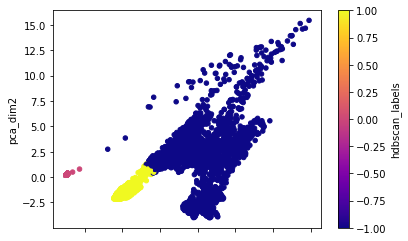

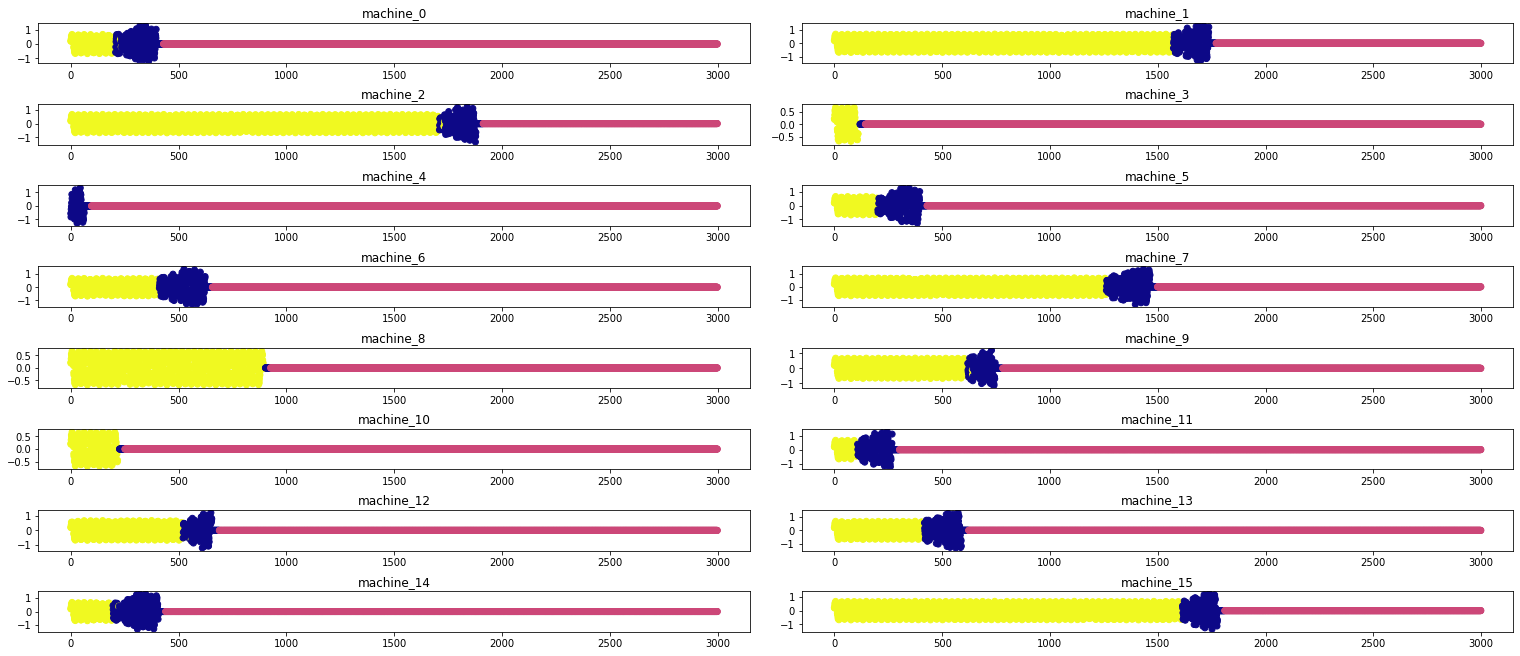

In [30]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, min_cluster_size=6000, prediction_data=True)

clusterer.fit(df_machine_data.loc[training_rows,training_cols].to_numpy())
df_machine_data.loc[training_rows, 'hdbscan_labels'] = clusterer.labels_
df_machine_data.loc[training_rows,:].plot.scatter('pca_dim1', 'pca_dim2', c = 'hdbscan_labels', colormap='plasma')
plt.show()

plot_ts(df_machine_data, training_sources, labelname = 'hdbscan_labels', min_val = -1, max_val = 1)

HDBSCAN demonstrated good performance on the validation set.

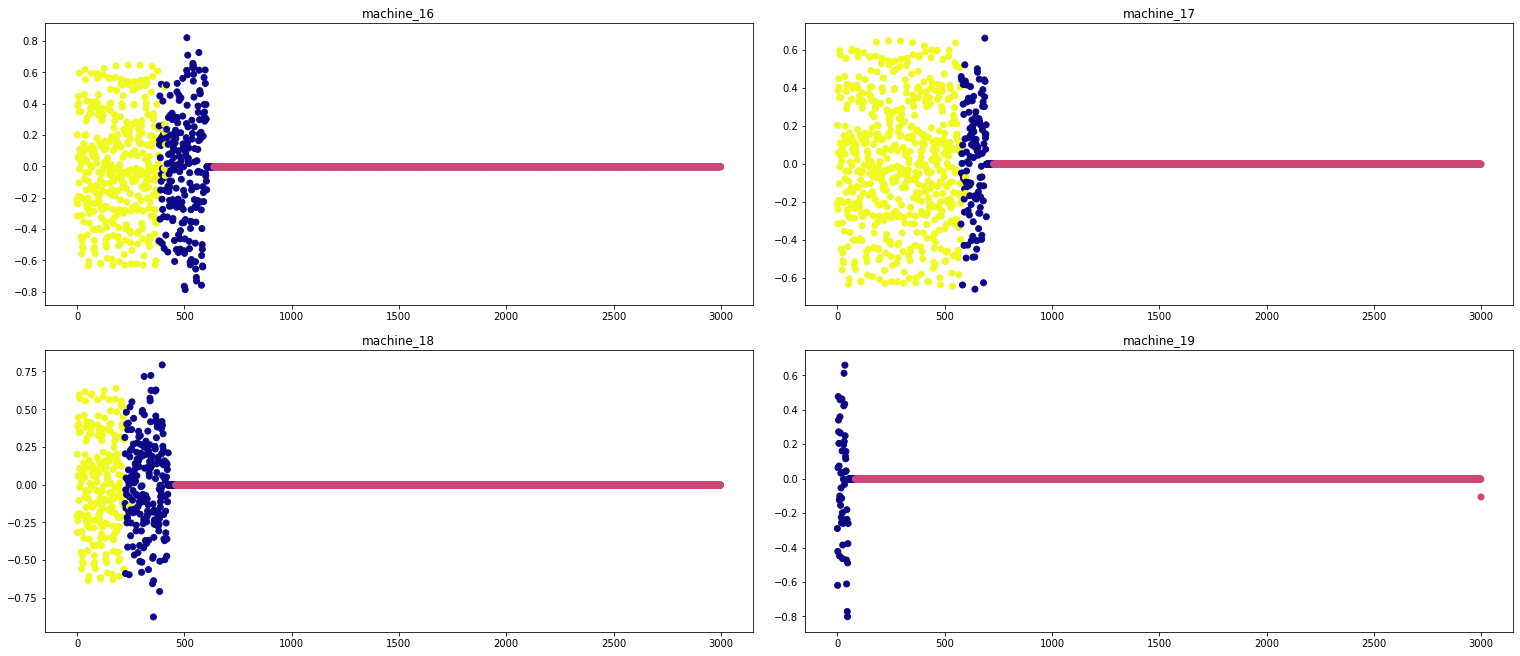

In [31]:
df_machine_data.loc[validation_rows, 'hdbscan_labels'], strengths = hdbscan.approximate_predict(clusterer, df_machine_data.loc[validation_rows, training_cols].to_numpy())

plot_ts(df_machine_data, validation_sources, labelname = 'hdbscan_labels', ts ='2_cleaned', min_val = -1, max_val = 1)

Messaging to ExampleCo Executives:
- Initial analysis reveals data point clusters that are clearly separate (over 3 sigma) from the rest of the data
- I removed these datapoints, replaced them with interpolated values and then smoothed the curves using a moving 
- Using time series analysis tools, I can decompose the machines' signal into metrics (amplitude of the most significant harmonic and total harmonic distortion) that are useful in determining its state (normal, faulty, failed)
- Applying Kmeans and HBDSCAN unsupervised learning algorithms, I can  cluster the datapoints into 3-4 states which are suspected to correspond to our operating modes of interest. (K-means identified two faulty clusters).
- [Internal] Most compeling visual is below using HBDSCAN
    - Yellow --> normal
    - Blue --> faulty
    - Pink --> failed

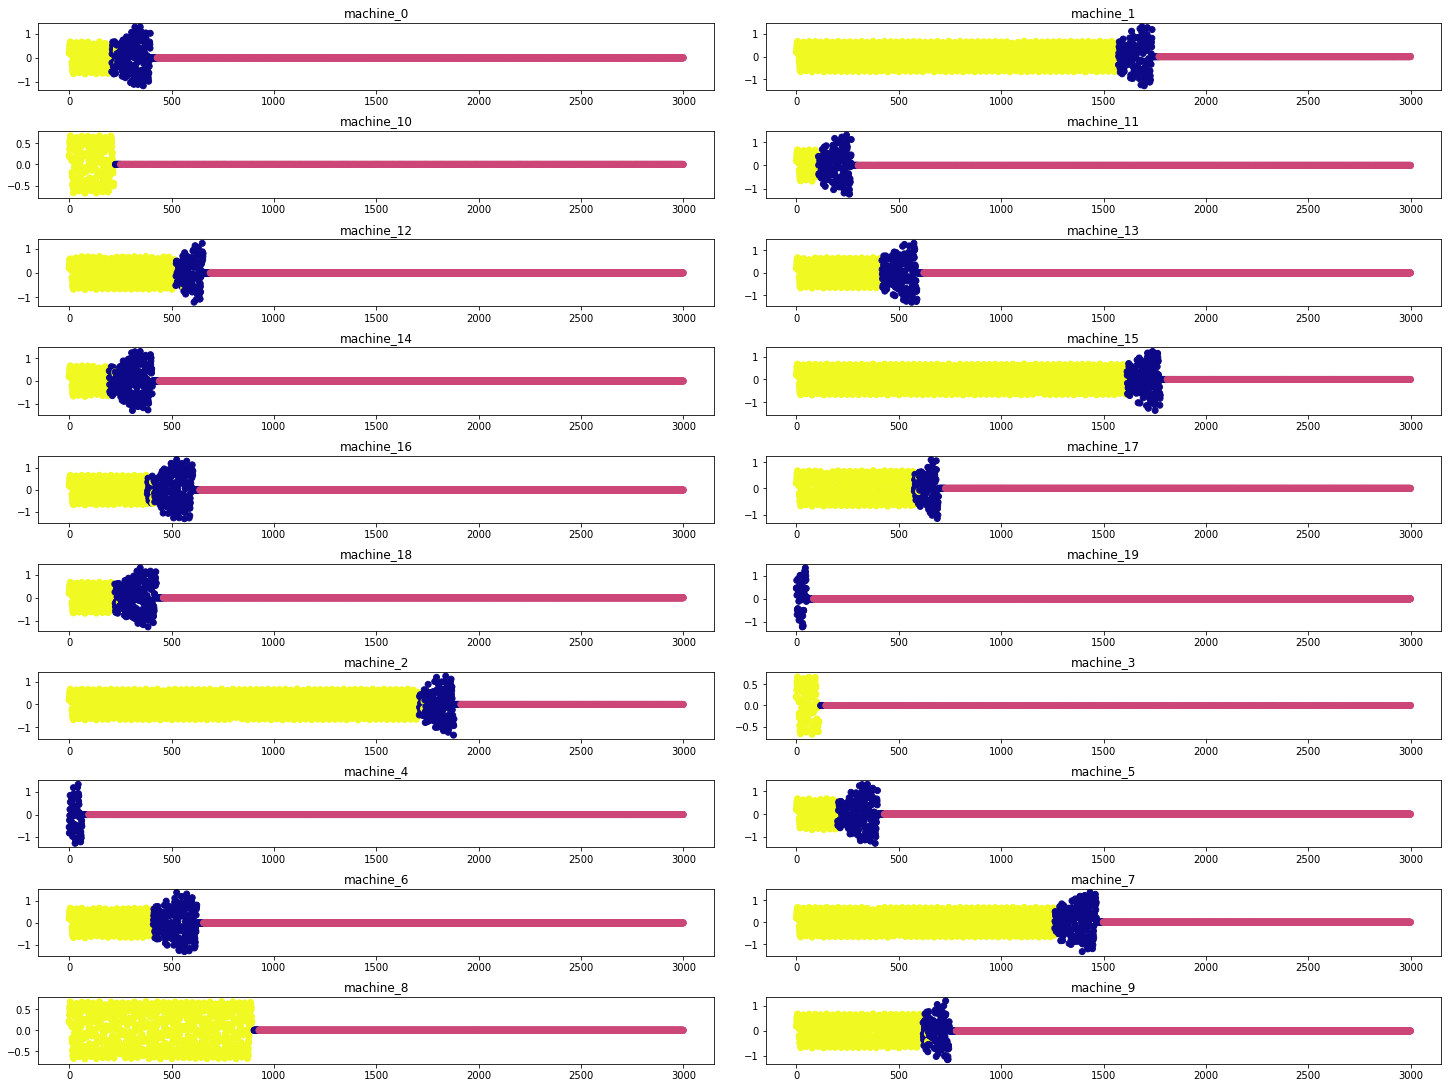

In [32]:
plot_ts(df_machine_data, all_sources, figheight = 20, figwidth = 15, labelname = 'hdbscan_labels', min_val = -1, max_val = 1)